# Import

In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from fvcore.nn import FlopCountAnalysis, flop_count_table
import numpy as np
import matplotlib.pyplot as plt
import os
####################################################
from src.Mydataloader import LoadDataset
from src.Mymodel import Block
from src.Mymodel import MyResNet34
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining

# Setup

In [2]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Model selection for CIFAR"""
NUM_LAYERS_LEVEL = 5

"""Dataset parameters"""
BATCH = 256
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True
SPLIT_RATIO = 0.95
"""optimizer parameters"""
OPTIMIZER = "SGD"
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"

"""Learning rate scheduler parameters"""
LOAD_BEFORE_TRAINING = False
LOAD_BEFORE_TRAINING = True
NUM_EPOCHS = 5000

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 1200
file_path = ""
if DATASET == "ImageNet2012":
    file_path = f"{DATASET}/MyResNet34_{BATCH}_{OPTIMIZER}"
else:
    file_path = f"{DATASET}/MyResNet{NUM_LAYERS_LEVEL*6+2}_{BATCH}_{OPTIMIZER}"
    
if SPLIT_RATIO != 0:
    file_path += f"_{int(SPLIT_RATIO*100)}"

In [3]:
file_path

'CIFAR10/MyResNet32_256_SGD_95'

# Loading the dataset

## Define Dateloader

In [4]:
from src.Mydataloader import LoadDataset

In [5]:
tmp = LoadDataset(root="data", seceted_dataset=DATASET, split_ratio=SPLIT_RATIO)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

/home/lee/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  47500
- Length of Valid Set :  2500
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [6]:
train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH,
    shuffle=SHUFFLE,
    num_workers=NUMOFWORKERS,
    pin_memory=PIN_MEMORY,
    # pin_memory_device="cuda",
    persistent_workers=True,
)
print("train.transforms =", train_data.transform, train_dataloader.batch_size)

if SPLIT_RATIO != 0:
    valid_dataloader = DataLoader(
        valid_data,
        batch_size=BATCH,
        shuffle=SHUFFLE,
        num_workers=NUMOFWORKERS,
        pin_memory=PIN_MEMORY,
        # pin_memory_device="cuda",
        persistent_workers=True,
    )
    print("valid.transforms =", valid_data.transform, valid_dataloader.batch_size)
elif SPLIT_RATIO == 0:
    valid_dataloader = None
    
test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH,
    shuffle=SHUFFLE,
    num_workers=NUMOFWORKERS,
    pin_memory=PIN_MEMORY,
    # pin_memory_device="cuda",
    persistent_workers=True,
)
print("test.transforms =", test_data.transform, test_dataloader.batch_size)

train.transforms = Compose(
      ToTensor()
      Submean()
      AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.CIFAR10)
      RandomHorizontalFlip(p=0.5)
) 256
valid.transforms = Compose(
      ToTensor()
      Submean()
) 256
test.transforms = Compose(
      ToTensor()
      Submean()
) 256


## Confirm that the dataset is loaded properly

In [7]:
if DATASET != "ImageNet2012":
    for X, y in test_dataloader:
        print(f"Shape of X [N, C, H, W]: {X.shape}")
        print("mean of X", X.mean(dim=(0, 2, 3)))
        print(f"Shape of y: {y.shape} {y.dtype}")
        break

Shape of X [N, C, H, W]: torch.Size([256, 3, 32, 32])
mean of X tensor([-4.7160e-09, -3.3561e-09, -2.1952e-09])
Shape of y: torch.Size([256]) torch.int64


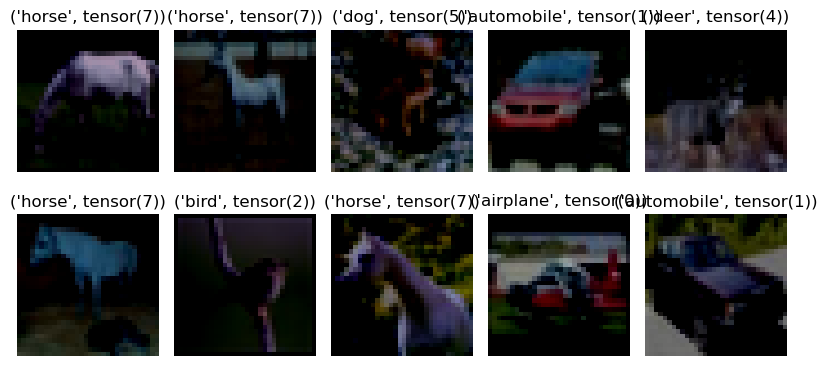

In [8]:
if DATASET != "ImageNet2012":
    class_names = test_dataloader.dataset.classes
    count = 0
    fig, axs = plt.subplots(2, 5, figsize=(8, 4))

    for images, labels in test_dataloader:
        images = images.numpy()

        for i in range(len(images)):
            image = images[i]
            label = labels[i]
            image = np.transpose(image, (1, 2, 0))
            image = np.clip(image, 0, 1)
            ax = axs[count // 5, count % 5]
            ax.imshow(image)
            ax.set_title(f"{class_names[label], label}")
            ax.axis('off')
            count += 1
            
            if count == 10:
                break
        if count == 10:
            break
    plt.tight_layout()
    plt.show()

# Define ResNet

In [9]:
from src.Mymodel import MyResNet34
from src.Mymodel import MyResNet_CIFAR

## Model Confirm

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
if DATASET == "CIFAR10" or DATASET == "CIFAR100":
    """ResNet{20, 32, 44, 56, 110, 1202} for CIFAR"""
    model = MyResNet_CIFAR(
        num_classes=COUNT_OF_CLASSES, num_layer_factor=NUM_LAYERS_LEVEL
    ).to(device)
    print(f"ResNet-{5*6+2} for {DATASET} is loaded.")

elif DATASET == "ImageNet2012":
    """ResNet34 for ImageNet 2012"""
    model = MyResNet34(num_classes=COUNT_OF_CLASSES).to(device)
    # model = models.resnet34(pretrained=True).to(device)
    # model = models.resnet34(pretrained=False).to(device)
    print(f"ResNet-34 for {DATASET} is loaded.")

# model.named_modules

ResNet-32 for CIFAR10 is loaded.


In [12]:
tmp_input = torch.rand(BATCH, 3, 32, 32).to(device)
flops = FlopCountAnalysis(model, tmp_input)
print(flop_count_table(flops))

| module                   | #parameters or shape   | #flops     |
|:-------------------------|:-----------------------|:-----------|
| model                    | 0.464M                 | 17.997G    |
|  conv32blocks            |  23.792K               |  6.363G    |
|   conv32blocks.0         |   0.432K               |   0.113G   |
|    conv32blocks.0.weight |    (16, 3, 3, 3)       |            |
|   conv32blocks.1         |   4.672K               |   1.25G    |
|    conv32blocks.1.conv1  |    2.304K              |    0.604G  |
|    conv32blocks.1.bn1    |    32                  |    20.972M |
|    conv32blocks.1.conv2  |    2.304K              |    0.604G  |
|    conv32blocks.1.bn2    |    32                  |    20.972M |
|   conv32blocks.2         |   4.672K               |   1.25G    |
|    conv32blocks.2.conv1  |    2.304K              |    0.604G  |
|    conv32blocks.2.bn1    |    32                  |    20.972M |
|    conv32blocks.2.conv2  |    2.304K              |    0.604

# Define Training

## Define Optimazer
#### ResNet32 for CIFAR10
- SGD
- Batch size = 128 * 2 GPU
- lr : 0.1 -> 0.01 -> 0.001 (at 32k, 48k and terminate on 64k iter)
  - divided by 10 when the error plateaus
- Weight Decay = 0.0001
- Momentum = 0.9
#### ResNet34 for ImageNet2012
- SGD
- Batch size = 256
- lr = 0.1
  - divided by 10 when the error plateaus
  - amount 60k iter
- Weight Decay = 0.0001
- Momentum = 0.9

In [13]:
criterion = nn.CrossEntropyLoss()

if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-4)
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001
    )

## Define Early Stopping

In [14]:
# Early stopping 관련 변수 초기화
best_val_loss = float("inf")
early_stop_counter = 0

## Define Learning Rate schedualer

In [15]:
scheduler_mapping = {"CIFAR100": 100, "CIFAR10": 1000, "ImageNet2012": 30}
MIN_LR = 0.0001
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",
    patience=scheduler_mapping[DATASET],
    factor=0.1,
    verbose=True,
    threshold=1e-4,
    min_lr=MIN_LR,
)

In [16]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [17]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

if LOAD_BEFORE_TRAINING == True and os.path.exists("logs/" + file_path + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        "logs/" + file_path + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_path)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []

    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
    }
    print("File does not exist. Created a new log.")

Suceessfully loaded the All setting and Log file.
CIFAR10/MyResNet32_256_SGD_95
Current epoch is 2032
Current learning rate: 0.1


In [18]:
# CHECK = 1999
# logs["train_loss"] = logs["train_loss"][:CHECK]
# logs["train_acc"] = logs["train_acc"][:CHECK]
# logs["valid_loss"] = logs["valid_loss"][:CHECK]
# logs["valid_acc"] = logs["valid_acc"][:CHECK]
# logs["test_loss"] = logs["test_loss"][:CHECK]
# logs["test_acc"] = logs["test_acc"][:CHECK]
# model.load_state_dict(torch.load(f"models/{file_path}.pth"))

# [Training Loop]

In [19]:
from src.Mytraining import DoTraining

In [20]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    device=device,
    logs=logs,
    file_path=file_path,
)
pre_epochs = len(Training.logs["train_loss"])

for epoch in range(NUM_EPOCHS):
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    # Early stopping check
    if eval_loss < best_val_loss:
        best_val_loss = eval_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "models/" + file_path + ".pth")

    else:
        early_stop_counter += 1
        if early_stop_counter >= EARLYSTOPPINGPATIENCE:
            print(f"Early stopping after {epoch} epochs without improvement.")
            break

    print("-" * 50)

[Epoch 2033/5000] :


100%|██████████| 186/186 [00:13<00:00, 13.87it/s]

Train Loss: 0.0004 | Train Acc: 98.57%


Valid Loss: 0.1045 | Valid Acc: 96.08%
Test  Loss: 0.8547 | Test Acc: 82.19%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2034/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.15it/s]


Train Loss: 0.0001 | Train Acc: 99.29%
Valid Loss: 0.2215 | Valid Acc: 93.24%
Test  Loss: 0.9624 | Test Acc: 80.50%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2035/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.86it/s]


Train Loss: 0.0003 | Train Acc: 97.86%
Valid Loss: 0.1968 | Valid Acc: 93.40%
Test  Loss: 0.9153 | Test Acc: 80.33%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2036/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.35it/s]


Train Loss: 0.0002 | Train Acc: 98.57%
Valid Loss: 0.0610 | Valid Acc: 97.72%
Test  Loss: 0.7335 | Test Acc: 84.21%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2037/5000] :


100%|██████████| 186/186 [00:11<00:00, 15.50it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.0478 | Valid Acc: 98.32%
Test  Loss: 0.7411 | Test Acc: 84.34%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2038/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.64it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.0325 | Valid Acc: 98.84%
Test  Loss: 0.6992 | Test Acc: 85.02%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2039/5000] :


100%|██████████| 186/186 [00:13<00:00, 14.22it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.0190 | Valid Acc: 99.44%
Test  Loss: 0.6860 | Test Acc: 85.52%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2040/5000] :


100%|██████████| 186/186 [00:13<00:00, 14.11it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.0144 | Valid Acc: 99.52%
Test  Loss: 0.6615 | Test Acc: 85.88%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2041/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.70it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.0126 | Valid Acc: 99.52%
Test  Loss: 0.6500 | Test Acc: 85.99%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2042/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.14it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.0118 | Valid Acc: 99.64%
Test  Loss: 0.6368 | Test Acc: 85.98%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2043/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.33it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.0118 | Valid Acc: 99.60%
Test  Loss: 0.6213 | Test Acc: 86.03%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2044/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.47it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.0116 | Valid Acc: 99.64%
Test  Loss: 0.6009 | Test Acc: 85.97%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2045/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.98it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.0123 | Valid Acc: 99.60%
Test  Loss: 0.6029 | Test Acc: 86.07%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2046/5000] :


100%|██████████| 186/186 [00:13<00:00, 14.14it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.0123 | Valid Acc: 99.68%
Test  Loss: 0.6067 | Test Acc: 86.05%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2047/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.08it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.0129 | Valid Acc: 99.60%
Test  Loss: 0.5855 | Test Acc: 86.05%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2048/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.93it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.0123 | Valid Acc: 99.64%
Test  Loss: 0.5744 | Test Acc: 86.02%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2049/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.05it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.0124 | Valid Acc: 99.60%
Test  Loss: 0.5687 | Test Acc: 86.07%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2050/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.83it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.0124 | Valid Acc: 99.72%
Test  Loss: 0.5876 | Test Acc: 86.21%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2051/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.75it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.0124 | Valid Acc: 99.64%
Test  Loss: 0.5850 | Test Acc: 86.05%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2052/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.47it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.0121 | Valid Acc: 99.68%
Test  Loss: 0.5778 | Test Acc: 86.10%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2053/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.44it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.0128 | Valid Acc: 99.72%
Test  Loss: 0.5673 | Test Acc: 86.09%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2054/5000] :


100%|██████████| 186/186 [00:11<00:00, 16.02it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.0119 | Valid Acc: 99.80%
Test  Loss: 0.5536 | Test Acc: 86.17%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2055/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.45it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.0124 | Valid Acc: 99.76%
Test  Loss: 0.5649 | Test Acc: 86.32%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2056/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.06it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.0135 | Valid Acc: 99.76%
Test  Loss: 0.5457 | Test Acc: 86.12%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2057/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.78it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.0131 | Valid Acc: 99.76%
Test  Loss: 0.5470 | Test Acc: 86.20%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2058/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.13it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.0133 | Valid Acc: 99.80%
Test  Loss: 0.5712 | Test Acc: 85.93%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2059/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.82it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.0130 | Valid Acc: 99.80%
Test  Loss: 0.5437 | Test Acc: 86.13%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2060/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.11it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.0132 | Valid Acc: 99.72%
Test  Loss: 0.5473 | Test Acc: 86.30%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2061/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.08it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.0145 | Valid Acc: 99.76%
Test  Loss: 0.5402 | Test Acc: 86.28%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2062/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.09it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.0146 | Valid Acc: 99.68%
Test  Loss: 0.5385 | Test Acc: 86.12%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2063/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.89it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.0142 | Valid Acc: 99.68%
Test  Loss: 0.5481 | Test Acc: 86.14%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2064/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.21it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.0153 | Valid Acc: 99.68%
Test  Loss: 0.5405 | Test Acc: 86.04%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2065/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.12it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.0160 | Valid Acc: 99.60%
Test  Loss: 0.5457 | Test Acc: 85.96%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2066/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.00it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.0164 | Valid Acc: 99.56%
Test  Loss: 0.5515 | Test Acc: 86.14%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2067/5000] :


100%|██████████| 186/186 [00:11<00:00, 16.58it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.0158 | Valid Acc: 99.64%
Test  Loss: 0.5498 | Test Acc: 86.03%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2068/5000] :


  6%|▌         | 11/186 [00:00<00:09, 18.06it/s]


KeyboardInterrupt: 

## Training Results

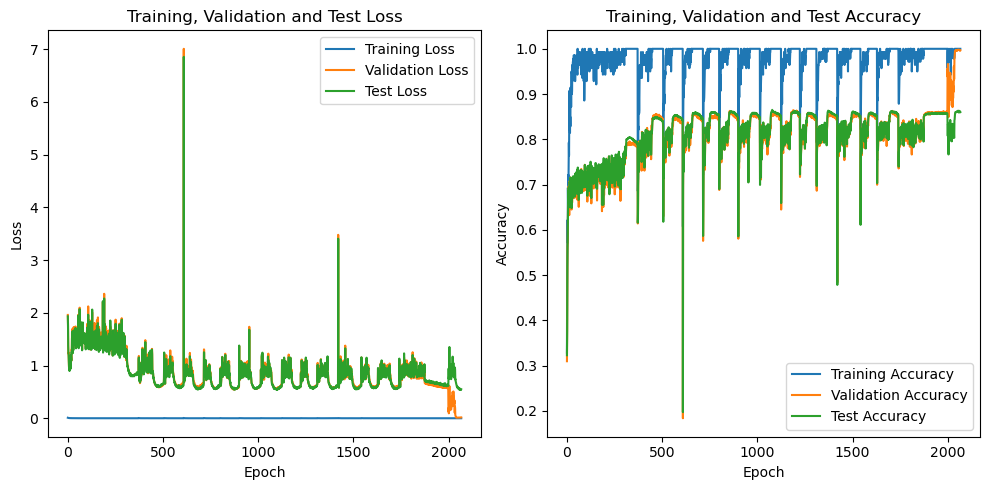

In [21]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

# 첫 번째 그래프: Training and Test Loss
axs[0].plot(logs["train_loss"], label="Training Loss")
axs[0].plot(logs["valid_loss"], label="Validation Loss")
axs[0].plot(logs["test_loss"], label="Test Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training, Validation and Test Loss")
axs[0].legend()

# 두 번째 그래프: Training and Test Accuracy
axs[1].plot(logs["train_acc"], label="Training Accuracy")
axs[1].plot(logs["valid_acc"], label="Validation Accuracy")
axs[1].plot(logs["test_acc"], label="Test Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Training, Validation and Test Accuracy")
axs[1].legend()

# 그래프를 보여줍니다.
plt.tight_layout()
plt.show()

In [22]:
print(len(logs["train_loss"]))
print(len(logs["train_acc"]))
print(len(logs["valid_loss"]))
print(len(logs["valid_acc"]))
print(len(logs["test_loss"]))
print(len(logs["test_acc"]))

2067
2067
2067
2067
2067
2067


- 주피터노트북 output set
- @tag:notebookOutputLayout

In [23]:
for i in range(len(logs["train_loss"])):
    print(
        f"{i+1} epoch: train_loss={logs['train_loss'][i]:.4f}, train_acc={logs['train_acc'][i]:.4f}, test_loss={logs['test_loss'][i]:.4f}, test_acc={logs['test_acc'][i]:.4f}"
    )

1 epoch: train_loss=0.0096, train_acc=0.3286, test_loss=1.9331, test_acc=0.3229
2 epoch: train_loss=0.0078, train_acc=0.4786, test_loss=1.7547, test_acc=0.3763
3 epoch: train_loss=0.0072, train_acc=0.5357, test_loss=1.3648, test_acc=0.5151
4 epoch: train_loss=0.0060, train_acc=0.6214, test_loss=1.2351, test_acc=0.5640
5 epoch: train_loss=0.0061, train_acc=0.5714, test_loss=1.2084, test_acc=0.5831
6 epoch: train_loss=0.0045, train_acc=0.6929, test_loss=1.0937, test_acc=0.6214
7 epoch: train_loss=0.0049, train_acc=0.6571, test_loss=0.9737, test_acc=0.6645
8 epoch: train_loss=0.0042, train_acc=0.7214, test_loss=0.9108, test_acc=0.6854
9 epoch: train_loss=0.0039, train_acc=0.7000, test_loss=1.0192, test_acc=0.6593
10 epoch: train_loss=0.0039, train_acc=0.7500, test_loss=0.8971, test_acc=0.6930
11 epoch: train_loss=0.0030, train_acc=0.7929, test_loss=1.0366, test_acc=0.6653
12 epoch: train_loss=0.0035, train_acc=0.7643, test_loss=1.0601, test_acc=0.6713
13 epoch: train_loss=0.0025, train_ac